# Анализ бизнес-показателей. Аналитика в Яндекс.Афише

На основе данных пользователей Яндекс.Афиши необходимо вывести основные бизнес-метрики и дать рекомендации для увеличения активности пользователей.

## Часть 1. Предобработка данных.

In [1]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
# Import datasets
costs = pd.read_csv('costs.csv')
orders_log = pd.read_csv('orders_log.csv')
visits_log = pd.read_csv('visits_log.csv')

In [2]:
# type of data: costs
print('----- costs -----')
print(costs.info())
print()
print(costs.columns)
print()
# type of data: orders_log
print('----- orders_log -----')
print(orders_log.info())
print()
print(orders_log.columns)
print()
# type of data: costs
print('----- visits_log -----')
print(visits_log.info())
print()
print(visits_log.columns)
print()

----- costs -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

Index(['source_id', 'dt', 'costs'], dtype='object')

----- orders_log -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

----- visits_log -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data colum

На начальном этапе были загружены три базы данных: costs (затраты на конкретный рекламный источник в конкретный день), orders_log (информация о заказах), visits_log (лог сервера с информацией о посещениях сайта).

Первичная проверка типов данных показала, что в каждой БД необходимо привести даты к нужному формату. Также в БД visits_log и orders_log столбцы Uid имеют целочисленный тип uint64 (могут принимать целочисленные неотрицательные значения.

In [3]:
#examine the display of dates
print('----- costs -----')
print(costs.head(2))
print('----- orders_log -----')
print(orders_log.head(2))
print('----- visits_log -----')
print(visits_log.head(2))

----- costs -----
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
----- orders_log -----
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
----- visits_log -----
    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  


In [4]:
# Change type to datetime
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
orders_log['Buy Ts'] = pd.to_datetime(orders_log['Buy Ts'], format='%Y-%m-%d %H:%M:%S')
visits_log['End Ts'] = pd.to_datetime(visits_log['End Ts'], format='%Y-%m-%d %H:%M:%S')
visits_log['Start Ts'] = pd.to_datetime(visits_log['Start Ts'], format='%Y-%m-%d %H:%M:%S')

Данные были приведены к нужному формату.

Проверим нечисловой категоральный столбец visits_log['Device']. После этого выполним проверку на дубликаты.

In [5]:
# Device check unique values
print(visits_log['Device'].value_counts())
# Checking duplicates
print()
print('----- costs -----')
print(costs.duplicated().sum())
print('----- orders_log -----')
print(orders_log.duplicated().sum())
print('----- visits_log -----')
print(visits_log.duplicated().sum())

desktop    262567
touch       96833
Name: Device, dtype: int64

----- costs -----
0
----- orders_log -----
0
----- visits_log -----
0


Основная проверка завершена, можно сделать первые выводы.

### Вывод. Предобработка данных.

Данные загружены и приведены к нужному формату.

Во всех БД нет пропусков и полных дубликатов. Можно переходить к исследовательскому анализу данных.

#### Исследование данных.

На данном этапе необходимо проверить распределение некоторых числовых значений: costs и Revenue. 

----- costs -----
count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64


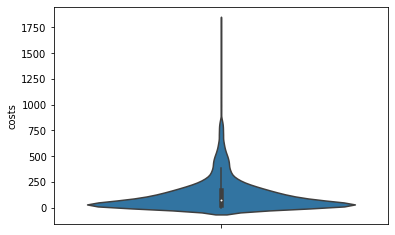


----- orders_log -----
count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64


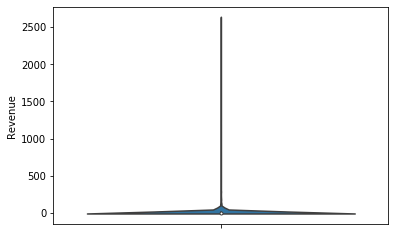

In [6]:
#create violin boxplot and prepare description
print('----- costs -----')
print(costs['costs'].describe())
sb.violinplot(y = "costs", data=costs)  
plt.show()
print()
print('----- orders_log -----')
print(orders_log['Revenue'].describe())
sb.violinplot(y = "Revenue", data=orders_log)   
plt.show() 

В столбце costs явно есть выбросы: в отдельные дни на рекламу было потрачено большое количество денежных средств. Исследуем более подробно этот столбец. Посмотрим, сколько значений статистически являются выбросами, а также, есть ли у них что-то общее.

Сейчас можно сказать, что в обычно расходы в день не превышают 170 рублей. Наиболее часто они составляют около 70-90 рублей. Расходы свыше 400 рублей в день уже можно назвать выбивающимися, однако наименьшее количество экстремальных значений наблюдается при уровне ежедневных расходов от 800 рублей.

In [7]:
# data slice: costs > 800
costs_800 = costs.loc[costs['costs'] > 800].copy()
print('Число выбивающихся значений:', len(costs_800['costs']))
print()
print(costs_800)
#checking the criterion for eliminating excessive values
if (len(costs_800['costs']) / len(costs['costs'])) <= 0.01:
    print('Можно удалить')
else:
    print('Не удалять')

Число выбивающихся значений: 14

      source_id         dt    costs
853           3 2017-10-06   980.52
874           3 2017-10-27   824.66
881           3 2017-11-03   811.14
902           3 2017-11-24  1788.28
903           3 2017-11-25   803.14
905           3 2017-11-27   831.73
919           3 2017-12-11  1061.18
920           3 2017-12-12   802.27
936           3 2017-12-28   858.28
942           3 2018-01-03   844.63
975           3 2018-02-05   845.75
979           3 2018-02-09   822.49
1005          3 2018-03-07   996.15
1088          3 2018-05-31   822.30
Можно удалить


Таких источников 14, их можно удалить, не теряя точности модели, каждое выбивающееся значение принадлежит третьему источнику рекламы. Можно дополнительно посмотреть распределение стоимости третьего источника - возможно это изначально дорогой канал привлечения клиентов.

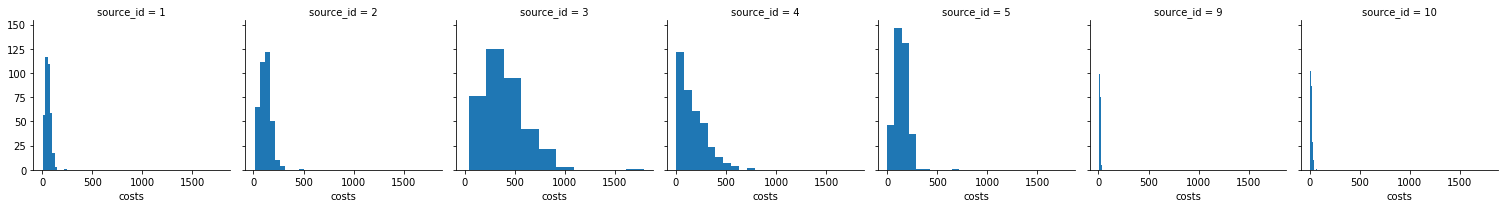

In [8]:
#histogram for source_id variations
g = sb.FacetGrid(costs, col="source_id")
g.map(plt.hist, "costs")
plt.show()

На графиках видно, что третий источник действительно в целом дороже. Пиковое значение - 250 рублей. Около ста наблюдений равны 500 рублям за привлечение клиентов.

Тем не менее, тенденция для каждого источника примерно одинакова - при пересечении рубежа в 500 рублей количество выбивающихся наблюдений резко падает.

Таким образом, можно удалить выбивающиеся значения.

In [9]:
costs = costs.loc[costs['costs'] < 800].copy()

Теперь перейдем к Revenue в БД orders_log. 

Исходя из Violin Boxplot, основные значения распределены от нуля до 6,5 рублей. Дополнительные исследования позволят определить количество выбивающихся значений, примерно понять, почему они появились, принять решение о возможности их удаления. 

In [10]:
# data slice: Revenue > 6,5
revenue_6p5 = orders_log.loc[orders_log['Revenue'] > 6.5].copy()
print('Число выбивающихся значений:', len(revenue_6p5['Revenue']))
print()
print(revenue_6p5)
#checking the criterion for eliminating excessive values
if (len(revenue_6p5['Revenue']) / len(orders_log['Revenue'])) <= 0.01:
    print('Можно удалить')
else:
    print('Не удалять')

Число выбивающихся значений: 8684

                   Buy Ts  Revenue                   Uid
0     2017-06-01 00:10:00    17.00  10329302124590727494
12    2017-06-01 10:33:00     9.78   8635489015105716934
16    2017-06-01 10:49:00     7.33   9454788256069675152
21    2017-06-01 11:13:00    10.00   1186685127129229501
30    2017-06-01 14:31:00     6.72  11139390829640167076
...                   ...      ...                   ...
50387 2018-05-31 22:26:00    17.60  11008267452526568440
50393 2018-05-31 22:57:00     6.60  12484396335714047199
50397 2018-05-31 23:02:00     7.33  10899818686660841329
50399 2018-05-31 23:04:00     7.33   3251741041959686640
50400 2018-05-31 23:13:00     6.72  11767206187037456942

[8684 rows x 3 columns]
Не удалять


Значений высоких комиссионных довольно много и нельзя просто удалить выбивающиеся значения. Дополнительная визуализация среза позволит понять, какие значения все же можно проигнорировать.

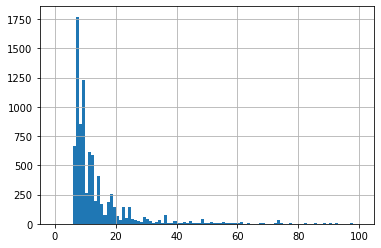

In [11]:
revenue_6p5['Revenue'].hist(bins=100, range=(0,100))
plt.show()

In [12]:
# data slice: Revenue > 100
revenue_100 = orders_log.loc[orders_log['Revenue'] > 100].copy()
print('Число выбивающихся значений:', len(revenue_100['Revenue']))
print()
print(revenue_100)
#checking the criterion for eliminating excessive values
if (len(revenue_100['Revenue']) / len(orders_log['Revenue'])) <= 0.01:
    print('Можно удалить')
else:
    print('Не удалять')

Число выбивающихся значений: 113

                   Buy Ts  Revenue                   Uid
42    2017-06-01 17:27:00   110.00  11218073356336199381
1392  2017-06-14 13:49:00   484.00    255246909617571582
3921  2017-07-19 10:19:00   102.67   2639824267109552297
4286  2017-07-24 09:08:00   110.00   6853820180456171909
6878  2017-09-05 12:27:00   205.33   9667577658644269267
...                   ...      ...                   ...
49936 2018-05-31 10:27:00   176.00  16022927424075233241
50021 2018-05-31 11:22:00   136.89  12788575116290203438
50025 2018-05-31 11:24:00   290.58  17296569523374666680
50030 2018-05-31 11:29:00   120.51   8497929650348693276
50113 2018-05-31 13:04:00   110.00  16588134534008032222

[113 rows x 3 columns]
Можно удалить


Итак, всего 113 визитов на сайт закончилось покупкой невероятно выгодной для сервиса Яндекс.Афиша.
Число наблюдений слишком мало, а значит, их можно удалить без потери точности статистических прогнозов в будущем.

In [13]:
#creating new orders_log DF with Revenue <100
orders_log = orders_log.loc[orders_log['Revenue'] < 100].copy()

----- costs -----
count    2528.000000
mean      125.015467
std       143.538109
min         0.540000
25%        21.857500
50%        76.810000
75%       167.742500
max       791.510000
Name: costs, dtype: float64


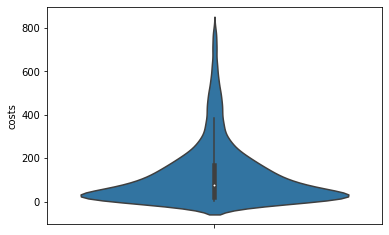


----- orders_log -----
count    50302.000000
mean         4.375163
std          6.508723
min          0.000000
25%          1.220000
50%          2.440000
75%          4.890000
max         99.000000
Name: Revenue, dtype: float64


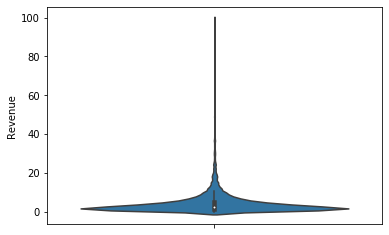

In [14]:
#create violin boxplot and prepare description for reniewed DFs
print('----- costs -----')
print(costs['costs'].describe())
sb.violinplot(y = "costs", data=costs)  
plt.show()
print()
print('----- orders_log -----')
print(orders_log['Revenue'].describe())
sb.violinplot(y = "Revenue", data=orders_log)   
plt.show() 

### Вывод. Исследование данных.

В этой части исследования мы обнаружили выбивающиеся параметры в двух столбцах двух разных БД. Изучив их подробнее мы удалили некоторые, тем самым сгладив возможные искажения будующих метрик (уменьшилось стандартное отклонение и среднее значение).

Причины появления выбивающих значений до конца не ясны. Пока понятно, что в БД costs они появляются у source_id = 3.

## Часть 2. Отчеты и метрики.

### Продукт

Рассчитаем абсолютные показатели DAU, MAU и WAU, чтобы понять, сколько пользователей обращаются к сервису в день, неделю и месяц соответственно. Первым шагом будет вычленение отдельных параметров даты из столбца Start Ts в БД visits_log. Затем, с помощью группировки можно получить необходимые метрики.

In [15]:
#extraction of date parameters
visits_log['start_dt'] = visits_log['Start Ts'].dt.date
visits_log['start_y'] = visits_log['Start Ts'].dt.year
visits_log['start_w'] = visits_log['Start Ts'].dt.week
visits_log['start_m'] = visits_log['Start Ts'].dt.month
#DAU, MAU и WAU calculation
dau = visits_log.groupby('start_dt').agg({'Uid':'nunique'}).mean()
wau = visits_log.groupby(['start_y','start_w']).agg({'Uid':'nunique'}).mean()
mau = visits_log.groupby(['start_y','start_m']).agg({'Uid':'nunique'}).mean()
#Sticky Factor (sf) calculation
sf_dw = dau / wau
sf_dm = dau / mau
#Nice output
print('Daily Active Users:', int(dau))
print('Weekly Active Users:', int(wau))
print('Monthly Active Users:', int(mau))
print()
print('Sticky Factor (week): {:.1%}'.format(sf_dw[0]))
print('Sticky Factor (month): {:.1%}'.format(sf_dm[0]))

Daily Active Users: 907
Weekly Active Users: 5716
Monthly Active Users: 23228

Sticky Factor (week): 15.9%
Sticky Factor (month): 3.9%


Итак, в среднем за рассматриваемый период, приложением пользовались 907 человек в день. В неделю пользователями сервиса Яндекс.Афиша стало 5716 человек. В месяц на платформу заходят 23228 пользователей. 

Чтобы как-то интерпретировать полученные значения, был рассчитан коэффициент лояльности пользователей, или sticky factor (SF). 16% - "возвратность" клиентов за неделю, т.е. за неделю 16% пользователей вошли повторно.
В масштабе месяца этот показатель сильно снижается до 4%. В зависимости от отрасли/приложения/сервиса показатель сильно разнится. Одно можно сказать - по крайней мере 4% пользователей становятся лояльными к севрису и возвращаются в него.

Используя вспомогательные столбцы с обозначением даты из предыдущего блока рассчитаем параметры сессии пользователя и Average Session Length (ASL)

In [16]:
#creating new df 'session_per_user'
session_per_user = visits_log.groupby(['start_y','start_m']).agg({'Uid':['count','nunique']})
session_per_user.columns = ['n_sessions','n_users']
session_per_user['sessions'] = session_per_user['n_sessions'] / session_per_user['n_users']
#Nice output
print(session_per_user.head(len(session_per_user['sessions'])))
print()
print('Среднее число сессий за год:',session_per_user['sessions'].mean())

                 n_sessions  n_users  sessions
start_y start_m                               
2017    6             16505    13259  1.244815
        7             17828    14183  1.256998
        8             14355    11631  1.234202
        9             23907    18975  1.259921
        10            37903    29692  1.276539
        11            43969    32797  1.340641
        12            41983    31557  1.330386
2018    1             36939    28716  1.286356
        2             37182    28749  1.293332
        3             35679    27473  1.298693
        4             26515    21008  1.262138
        5             26635    20701  1.286653

Среднее число сессий за год: 1.2808894945992668


По данным за год видно, что каждый пользователь в среднем использовал приложение 1-2 раза в месяц. Для агрегатора интереснейших событий выбранного города показатель относительно слабый. Визит на сайт еще не означает покупку, а значит - не означает прибыль компании. 

Рассчитаем ASL по данным той же БД.

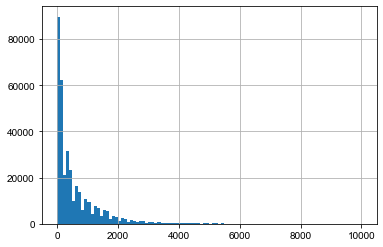

In [17]:
#ASL
visits_log['session_dur_sec'] = (visits_log['End Ts'] - visits_log['Start Ts']).dt.seconds
#Visualising
visits_log['session_dur_sec'].hist(bins=100, range=(0,10000))
sb.set_style('darkgrid')
plt.show()

In [18]:
#Distribution plot does not resembles Poisson distribution.
session_dur_mode = visits_log['session_dur_sec'].mode()
session_dur_mean = visits_log['session_dur_sec'].mean()
session_dur_median = visits_log['session_dur_sec'].median()
#output
print('Значение',
      session_dur_mode[0],'встречается',
      visits_log.loc[visits_log['session_dur_sec']==60,'session_dur_sec'].count(),
      'раз')
print()
print('Среднее значение',session_dur_mean)
print('Медиана', session_dur_median)
print()

Значение 60 встречается 53029 раз

Среднее значение 643.506488592098
Медиана 300.0



Сначала был создан столбец с продолжительностью сессии в секундах. Посмотрев на распределение величин продолжительности сессии можно убедиться, что оно не соответствует распределению Пуассона, следовательно, среднее значение и медиана не могут быть использованы для определение ASL. 

Вместо этого была рассчитана мода. Наиболее частая сессия на Яндекс.Афише длится 60 секунд. Этого времени явно мало для совершения покупки или ознакомления с новинками, значит такое значение, скорее всего, говорит о проблеме с приложением или сайтом, или же с источником привлечения клиента. Следует изучить выборку с характерной длиной сессии.

-----Typical Device-----
desktop    35411
touch      17618
Name: Device, dtype: int64


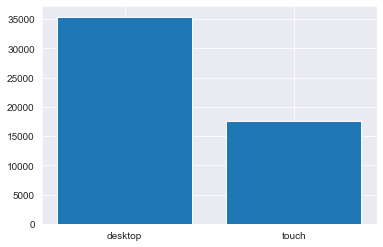

In [19]:
#creating data slice session_dur_sec = 60 sec   ['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']
bad_visits = visits_log.loc[visits_log['session_dur_sec']==60].copy()
print('-----Typical Device-----')
print(bad_visits['Device'].value_counts())
#Visualising Typical Device
fig, ax = plt.subplots()  
ax.bar(bad_visits['Device'].value_counts().index, bad_visits['Device'].value_counts())
sb.set_style('darkgrid')
plt.show()

-----Typical Source ID-----
4     15822
3     13521
5     11044
2      5902
1      3088
9      2095
10     1551
7         6
Name: Source Id, dtype: int64


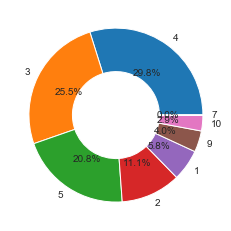

In [20]:
#data on typical Source Id
print('-----Typical Source ID-----')
print(bad_visits['Source Id'].value_counts())
#Visualising Typical Source ID
fig, ax = plt.subplots()
(ax.pie(
bad_visits['Source Id'].value_counts(),
labels=bad_visits['Source Id'].value_counts().index,
autopct='%1.1f%%',
rotatelabels=False,
wedgeprops=dict(width=0.5)))
plt.show()

Значения двух столбцов, которые мы подозревали сначала, были изучены.
Первая гипотеза, которую можно было выдвинуть, заключается в удобстве мобильной и ПК-версий сервиса. На первой диаграмме показано, что подавляющее большинство (но не все) коротких заходов было совершено через ПК. Таким образом, можно сделать вывод о том, что компьютерная версия "вылетает", или не совсем удобна пользователям. 

Для уточнения и подтверждения этой гипотезы необходимо отследить путь пользователей из выборки на сайте и в мобильном приложении (все же немало пользователей имели короткую сессию, заходя со смартфонов).

Были также проверены источники привлечения пользователей. Здесь нет совсем уж превалирующего "плохого" источника, однако при переходе с источников 3,4 и 5 наблюдается гораздо больше проблем. Возможно, проблема связана с неработающей ссылкой, или большим временем ожидания.

Косвенно величина возврата клиентов была посчитана. Это SF, который показывает лояльность пользователей сервиса. Однако более точным будет показатель Retention Rate. Рассчитаем его.

In [21]:
# creating monthly cohorts visits_log.columns: ['Device', 'End Ts', 'Source Id', 'Start Ts', 
# 'Uid', 'start_dt','start_y', 'start_w', 'start_m', 'session_dur_sec']
first_visit_date = visits_log.groupby('Uid')['Start Ts'].min()
first_visit_date.name = 'first_ts'
visits_log = visits_log.join(first_visit_date, on='Uid') #added new column with first session date&time
visits_log['start_ts_m'] = visits_log['Start Ts'].astype('datetime64[M]')
visits_log['first_ts_m'] = visits_log['first_ts'].astype('datetime64[M]') #extracted month

In [22]:
#lifetime calculation
visits_log['lifetime'] = visits_log['start_ts_m'] - visits_log['first_ts_m']
visits_log['lifetime'] = visits_log['lifetime'] / np.timedelta64(1,'M')
visits_log['lifetime'] = visits_log['lifetime'].round().astype('int')
visits_log['first_ts_m_str'] = visits_log['first_ts_m'].dt.strftime('%Y-%m')
visits_log['first_ts_m_str'] = pd.to_datetime(visits_log['first_ts_m_str'],format=('%Y-%m'))
#print(visits_log)

In [23]:
# new df for RR calculation
visits_log_cohorts = visits_log.groupby(['first_ts_m_str','lifetime']).agg({'Uid':'nunique'}).reset_index()

In [24]:
#user count in No 0 cohort
initial_users_count = visits_log_cohorts[visits_log_cohorts['lifetime'] == 0][['first_ts_m_str','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'Uid_cohorts'})

In [25]:
#adding Uid_cohorts to visits_log_cohorts
visits_log_cohorts = visits_log_cohorts.merge(initial_users_count,on='first_ts_m_str')
#calculating RR(Retention Rate)
visits_log_cohorts['RR'] = visits_log_cohorts['Uid'] / visits_log_cohorts['Uid_cohorts']

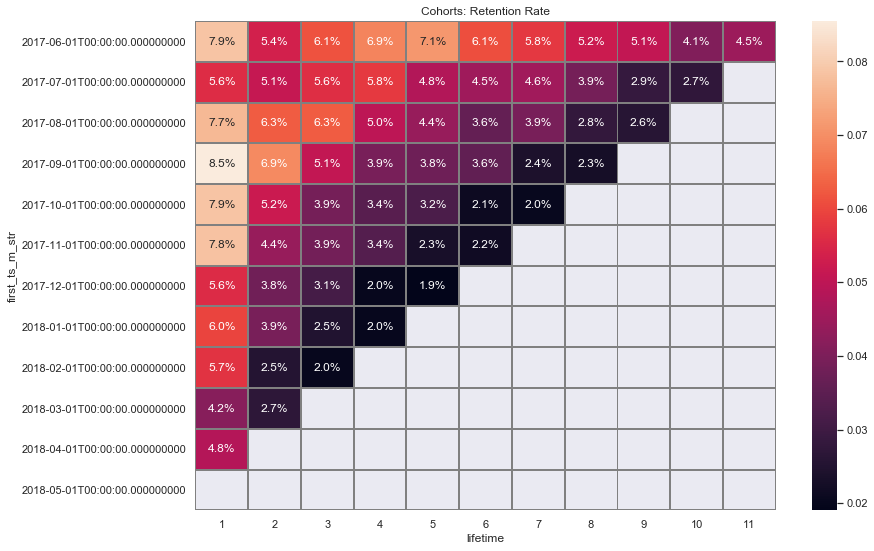

In [26]:
#RR pivot table and heatmap
RR_pivot = (visits_log_cohorts.pivot_table(
index='first_ts_m_str',
columns='lifetime',
values='RR',
aggfunc='sum'))
  
sb.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Retention Rate')
sb.heatmap(RR_pivot.loc[:,1:11], annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Таблица с RR(Retention Rate) построена и по ней можно сделать первые выводы. Поскольку RR базисного месяца несопоставим с последующими значениями, в итоговой тепловой карте нулевого столбца нет. 

RR спустя 1 месяц колеблется от 5% до 8%. Такова доля пользователей, которые возвращаются в приложение, причем рекордные показатели принадлежат когортам с августа по ноябрь 17-го года, а также июньской когорте того же года. Возможно для новых пользователей в эти периоды действовали скидки и специальные предложения, которые доказали свою эффективность. 

На тепловой карте также прослеживается некоторая сезонность: в период до конца осени (ноября 2017-го) пользователи, хоть и немного, но возвращаются в приложение. После этого показатели RR резко падают. С одной стороны, это может быть связано с большей активностью в теплое время года. С другой, необходимо свериться с рекламными кампаниями и стимулирующими предложениями для новых пользователей.

За год (исходя из показателей первой когорты) коэффициент удержания клиентов падает примерно на 40%.

### Продажи

Первой задачей является определение среднего времени, которое нужно пользователям для совершения покупки. Для подсчета этого значения можно объединить таблицы заказов и визитов на сайт. После этого все данные будут готовы.

In [27]:
#calculating first date of visit and first date of piurchase
first_order_log = orders_log.groupby('Uid')['Buy Ts'].min().reset_index()
first_visit_log = visits_log.groupby('Uid')['Start Ts'].min().reset_index()
first_order_log = first_order_log.merge(first_visit_log,on='Uid') #columns: ['Uid', 'Buy Ts', 'Start Ts']
print(first_order_log.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36509 entries, 0 to 36508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Uid       36509 non-null  uint64        
 1   Buy Ts    36509 non-null  datetime64[ns]
 2   Start Ts  36509 non-null  datetime64[ns]
dtypes: datetime64[ns](2), uint64(1)
memory usage: 1.1 MB
None


In [28]:
#changing date format
first_order_log['Buy Ts'] = first_order_log['Buy Ts'].dt.date
first_order_log['Start Ts'] = first_order_log['Start Ts'].dt.date

In [29]:
#calculating days before purchase (dbp)
first_order_log['dbp'] = first_order_log['Buy Ts'] - first_order_log['Start Ts']
first_order_log['dbp_number'] = first_order_log['dbp'] / np.timedelta64(1,'D') # turn to regular number

In [30]:
#statistics on dbp_number
print(first_order_log['dbp_number'].describe())
print()
print(first_order_log['dbp_number'].value_counts())

count    36509.000000
mean        16.898518
std         47.081674
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: dbp_number, dtype: float64

0.0      25030
1.0       1965
2.0        685
3.0        451
4.0        386
         ...  
312.0        1
338.0        1
309.0        1
307.0        1
341.0        1
Name: dbp_number, Length: 349, dtype: int64


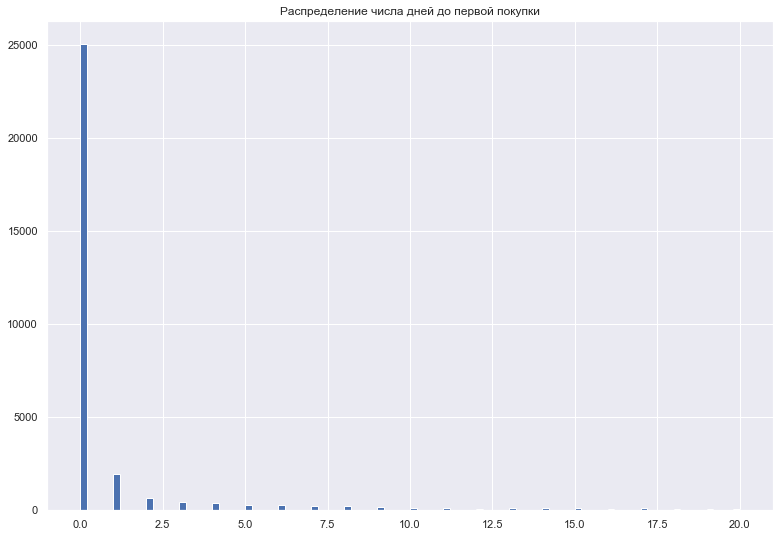

In [31]:
#visualising dbp
sb.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Распределение числа дней до первой покупки')
first_order_log['dbp_number'].hist(bins=100, range=(0,20))
plt.show()

Итак, мы видим, что бОльшая часть посетителей пользовались сервисом в свое первое посещение сайта(открытия приложения), либо в тот же день. Небольшое число пользователей возвращались к сервису Яндекс.Афиша только спустя год.

Это хорошие показатели. Теперь определим, какой из источников был настолько эффективен, что привел к совершению покупки сразу после первого знакомства с сервисом. Также стоит узнать устройство, с уоторого пользователям удобнее совершать покупки.

In [32]:
#adding buying and revenue info to logs df
first_order_source = visits_log[['Start Ts','End Ts','Uid','Device','Source Id']]

first_order_source = first_order_source.merge(orders_log, on=['Uid'],how='inner')
first_order_source = first_order_source[(first_order_source['Buy Ts'] >= first_order_source['Start Ts']) & 
                                         (first_order_source['Buy Ts'] <= first_order_source['End Ts'])]

In [33]:
#extracting dates 'Start Ts','End Ts','Buy Ts'
first_order_source['start_ts_date'] = first_order_source['Start Ts'].dt.date
first_order_source['end_ts_date'] = first_order_source['End Ts'].dt.date
first_order_source['buy_ts_date'] = first_order_source['Buy Ts'].dt.date

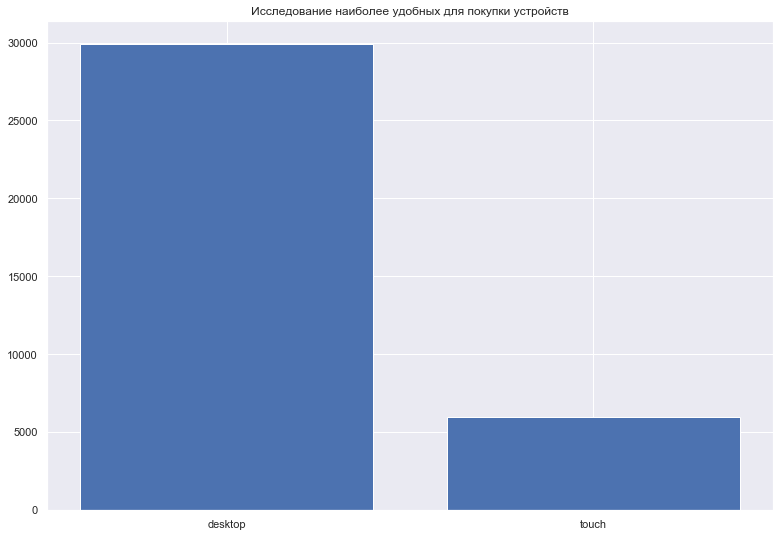

desktop    29886
touch       5984
Name: Device, dtype: int64


In [34]:
# visualising popular devices 
sb.set_style('darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Исследование наиболее удобных для покупки устройств')
plt.bar(first_order_source['Device'].value_counts().index, first_order_source['Device'].value_counts())
plt.show()
print(first_order_source['Device'].value_counts())

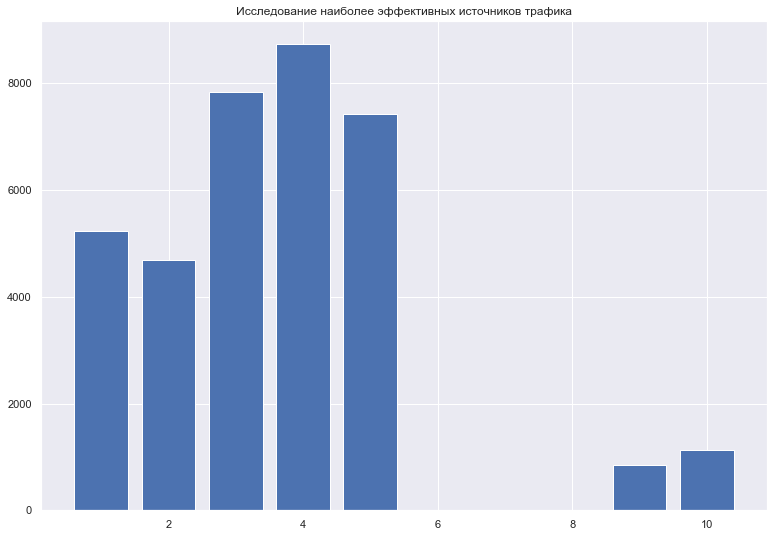

4     8728
3     7841
5     7420
1     5226
2     4681
10    1131
9      842
7        1
Name: Source Id, dtype: int64


In [35]:
# visualising popular sources 
sb.set_style('darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Исследование наиболее эффективных источников трафика')
plt.bar(first_order_source['Source Id'].value_counts().index, first_order_source['Source Id'].value_counts())
plt.show()
print(first_order_source['Source Id'].value_counts())

In [36]:
#making special data slice: start_ts_date = buy_ts_date - impulsive decision
impulsive_decision = first_order_source[first_order_source['start_ts_date'] == first_order_source['buy_ts_date']]
print(impulsive_decision.shape)

(35686, 10)


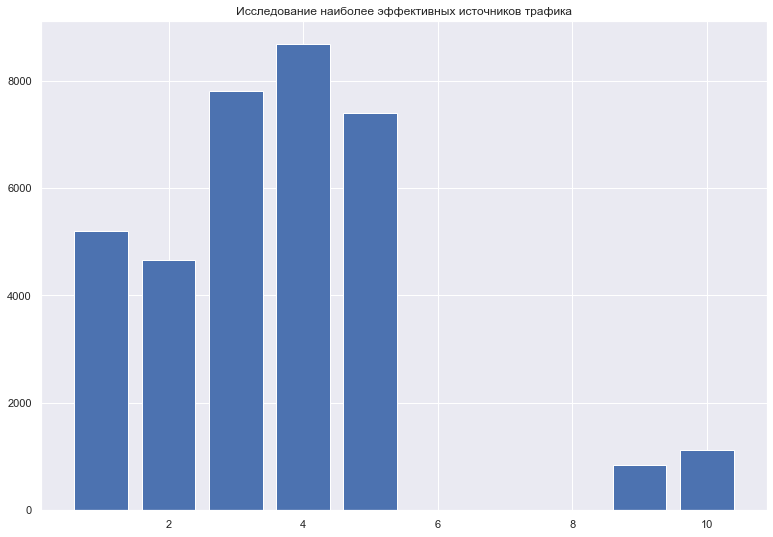

4     8674
3     7800
5     7387
1     5200
2     4662
10    1127
9      835
7        1
Name: Source Id, dtype: int64


In [37]:
#visualising impulsive decision
sb.set_style('darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Исследование наиболее эффективных источников трафика')
plt.bar(impulsive_decision['Source Id'].value_counts().index, impulsive_decision['Source Id'].value_counts())
plt.show()
print(impulsive_decision['Source Id'].value_counts())

### Вывод

На первой гистограмме "Распределение числа дней до первой покупки" видно, что большинство значений приходятся на 1-3 использование сервиса. Причем, большую часть покупок совершается во время первого визита на сервис.

Среди источников, обеспечивающих приход клиентов, лидируют 3,4,5. Срез данных по покупкам, совершенным во время первого обращения не внес никаких поправок в текущие выводы.

Произведем подсчет среднего числа покупок за день(Daily Average Purchases - DAP), неделю (Weekly Average Purchases - WAP), месяц (Monthly Average Purchases - MAP), год (Annual Average Purchases - AAP) 

In [38]:
#adding new columns
first_order_source['buy_ts_y'] = first_order_source['Buy Ts'].dt.year
first_order_source['buy_ts_w'] = first_order_source['Buy Ts'].dt.week
first_order_source['buy_ts_m'] = first_order_source['Buy Ts'].dt.month

In [39]:
# calculating dap,WAP,MAP,AAP
dap = first_order_source.groupby('buy_ts_date').agg({'Uid':'count'}).mean()
wap = first_order_source.groupby(['buy_ts_y','buy_ts_w']).agg({'Uid':'count'}).mean()
map = first_order_source.groupby(['buy_ts_y','buy_ts_m']).agg({'Uid':'count'}).mean()
aap = first_order_source['Uid'].count()

In [40]:
#nice output
print('Daily Average Purchases:', int(dap))
print('Weekly Average Purchases:', int(wap))
print('Monthly Average Purchases:', int(map))
print('Total Purchases:', int(aap))
print()
print()
print(first_order_source.groupby(['buy_ts_y','buy_ts_m']).agg({'Uid':'count'}))

Daily Average Purchases: 98
Weekly Average Purchases: 676
Monthly Average Purchases: 2759
Total Purchases: 35870


                    Uid
buy_ts_y buy_ts_m      
2017     6         1985
         7         1832
         8         1338
         9         2472
         10        4245
         11        3926
         12        4356
2018     1         3332
         2         3645
         3         3554
         4         2214
         5         2970
         6            1


### Вывод

В полученной небольшой статистике также можно проследить сезонность - среднее ежемесячное количество заказов увеличивается зимой (октябрь - декабрь) и падает летом.

Это вполне логично в нашей стране - люди приобретают билеты на различные мероприятия в период длинных выходных

#### Средний чек

Определим динамику изменения среднего чека по каждой когорте.

In [41]:
# create new df ('Buy Ts', 'Revenue', 'Uid')
orders_log_cohorts = orders_log.copy()

In [42]:
# creating monthly cohorts visits_log.columns: ['Device', 'End Ts', 'Source Id', 'Start Ts', 
# 'Uid', 'start_dt','start_y', 'start_w', 'start_m', 'session_dur_sec']
first_order_date = orders_log_cohorts.groupby('Uid')['Buy Ts'].min()
first_order_date.name = 'first_buy'
orders_log_cohorts = orders_log_cohorts.join(first_order_date, on='Uid') #added new column with first buy date&time
orders_log_cohorts['buy_ts_m'] = orders_log_cohorts['Buy Ts'].astype('datetime64[M]') #extracted month
orders_log_cohorts['first_buy_m'] = orders_log_cohorts['first_buy'].astype('datetime64[M]') #extracted month

In [43]:
#lifetime calculation
orders_log_cohorts['lifetime'] = orders_log_cohorts['buy_ts_m'] - orders_log_cohorts['first_buy_m']
orders_log_cohorts['lifetime'] = orders_log_cohorts['lifetime'] / np.timedelta64(1,'M')
orders_log_cohorts['lifetime'] = orders_log_cohorts['lifetime'].round().astype('int')
#print(orders_log_cohorts.head(10))

In [44]:
# new df for AB (Average Buy) calculation
orders_log_cohorts_AB = orders_log_cohorts.groupby(['first_buy_m','lifetime']).agg({'Uid':'nunique','Revenue':'sum'}).reset_index()

In [45]:
#Finding revenue_per_user
orders_log_cohorts_AB['revenue_per_user'] = (
    orders_log_cohorts_AB['Revenue'] / orders_log_cohorts_AB['Uid'])

In [46]:
#Creating pivot table with revenue per user
orders_log_cohorts_AB_pivot = orders_log_cohorts_AB.pivot_table(
    index='first_buy_m',
    columns='lifetime',
    values='revenue_per_user',
    aggfunc='mean')

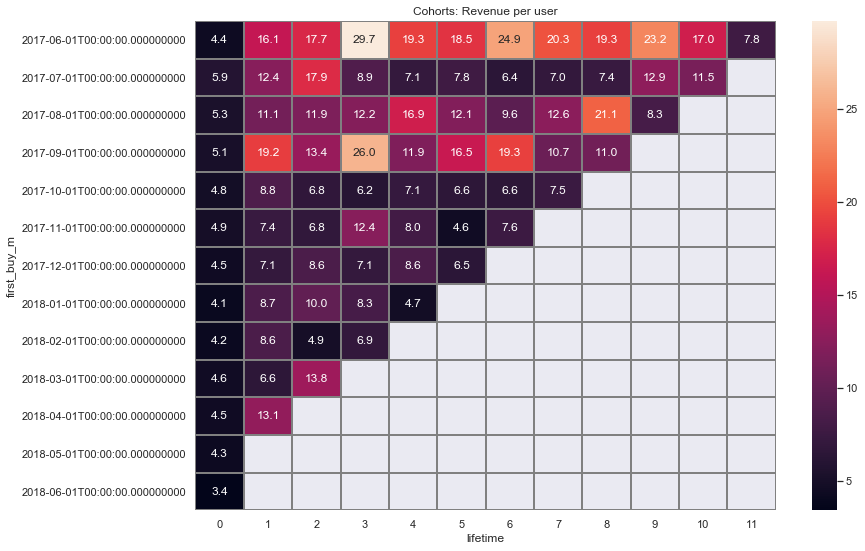

In [47]:
#creating the heatmap orders_log_cohorts_AB_pivot
sb.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Revenue per user')
sb.heatmap(orders_log_cohorts_AB_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

Мы получили статистику по изменению среднего чека для каждой когорты. Мы видим, что на последний рассмвтриваемый период для каждой когорты средний чек больше, чем аналогичное значение для базисного периода. Это означает, что пользователи, во-первых, не забывают о сервисе, а во вторых - пользуются им чаще (по крайней мере, приобретают билеты на бОльшие суммы, чем в базисном периоде).

Наиболее денежной является июньская когорта 2016-го: мы видим, что почти для каждого месяца средний чек за покупателя двузначный. Примечательно, что рекордные значения совпадают с "праздничными" месяцами: сентябрь (начало театрального сезона и окончание периода отпусков), декабрь (впереди новогодние праздники) и март (8 марта). Подобные закономерности справедливы и для когорт августа и сентября того же года

### Вывод

После изучения графика становится понятно, что при первом посещении клиенты тратят малые суммы, следовательно можно сделать особое предложение на 1-й заказ (акцию, побуждающую пользователя купить больше билетов, например)

Поскольку размер среднего чека подвержен сезонности, можно следить за появлением специальных сезонных предложений для клиентов в других, менее активных когортах.

#### LTV

Рассчитаем, какую прибыль приносит каждый клиент сервису со всех своих покупок за период своей активности. Для этого рассчитаем метрику LTV. Для большей наглядности сперва посчитаем общую величину, а затем сделаем разбивку по источникам привлечениям и устройствам.

In [48]:
# calculating number of buyers
orders_log_cohorts = orders_log_cohorts.rename(columns={'Buy Ts':'buy_ts'})
cohort_sizes = orders_log_cohorts.groupby('buy_ts').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['buy_ts', 'n_buyers']

In [49]:
# adding devices and sources
visits_log_stat = visits_log.groupby('Uid').agg({'Device':'first','Source Id':'first'}).reset_index()
print(visits_log_stat)

                         Uid   Device  Source Id
0             11863502262781    touch          3
1             49537067089222    touch          2
2            297729379853735  desktop          3
3            313578113262317  desktop          2
4            325320750514679  desktop          5
...                      ...      ...        ...
228164  18446403737806311543  desktop          5
228165  18446424184725333426    touch          4
228166  18446556406699109058    touch          3
228167  18446621818809592527  desktop          4
228168  18446676030785672386  desktop          3

[228169 rows x 3 columns]


In [50]:
# adding devices and sources part2
orders_log_cohorts = orders_log_cohorts.merge(visits_log_stat, on = 'Uid')
orders_log_cohorts.columns = ['buy_ts', 'revenue', 'uid', 'first_buy', 'buy_ts_m', 'first_buy_m','lifetime', 'device', 'source_Id']
# orders_log_cohorts.columns :'buy_ts', 'revenue', 'uid', 'first_buy', 'buy_ts_m', 
#     'first_buy_m','lifetime', 'device', 'source_Id'

In [51]:
#adding number of buyers
orders_log_cohorts = orders_log_cohorts.merge(cohort_sizes,on='buy_ts')
orders_log_cohorts['ltv'] = orders_log_cohorts['revenue'] / orders_log_cohorts['n_buyers']

In [52]:
# pivot table for ltv
ltv_pivot = orders_log_cohorts.pivot_table(index='first_buy_m', 
                               columns='lifetime', 
                               values='ltv', 
                               aggfunc='mean').round()

In [53]:
print(ltv_pivot)

lifetime      0     1    2     3    4    5     6    7    8     9    10   11
first_buy_m                                                                
2017-06-01   4.0   5.0  5.0   7.0  5.0  5.0   5.0  5.0  5.0   6.0  7.0  4.0
2017-07-01   5.0   6.0  8.0   5.0  4.0  3.0   4.0  5.0  5.0  12.0  5.0  NaN
2017-08-01   4.0   6.0  5.0   6.0  7.0  6.0   5.0  6.0  8.0   5.0  NaN  NaN
2017-09-01   4.0  11.0  7.0  13.0  9.0  9.0  10.0  6.0  7.0   NaN  NaN  NaN
2017-10-01   4.0   5.0  5.0   4.0  5.0  4.0   4.0  4.0  NaN   NaN  NaN  NaN
2017-11-01   4.0   4.0  4.0   6.0  4.0  3.0   4.0  NaN  NaN   NaN  NaN  NaN
2017-12-01   4.0   4.0  4.0   4.0  5.0  4.0   NaN  NaN  NaN   NaN  NaN  NaN
2018-01-01   3.0   4.0  5.0   5.0  3.0  NaN   NaN  NaN  NaN   NaN  NaN  NaN
2018-02-01   3.0   4.0  3.0   4.0  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
2018-03-01   4.0   3.0  4.0   NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
2018-04-01   4.0   4.0  NaN   NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
2018-05-01  

In [54]:
print(ltv_pivot.sum(axis=1))

first_buy_m
2017-06-01    63.0
2017-07-01    62.0
2017-08-01    58.0
2017-09-01    76.0
2017-10-01    35.0
2017-11-01    29.0
2017-12-01    25.0
2018-01-01    20.0
2018-02-01    14.0
2018-03-01    11.0
2018-04-01     8.0
2018-05-01     3.0
2018-06-01     3.0
dtype: float64


LTV каждой когорты был посчитан. Большее количество денег было получено с сентябрьской когорты (причем это не самая "старшая" из когорт).

Этот показатель лучше всего раскрывает себя в сравнении с расходами на привлечение одного клиента. Эта метрика будет выведена в следующем блоке, а на данном этапе мы можем построить аналогичные таблицы и диаграммы с разбивкой по устройсквам и источникам привлечения. 

LTV ПО ИСТОЧНИКУ № 1


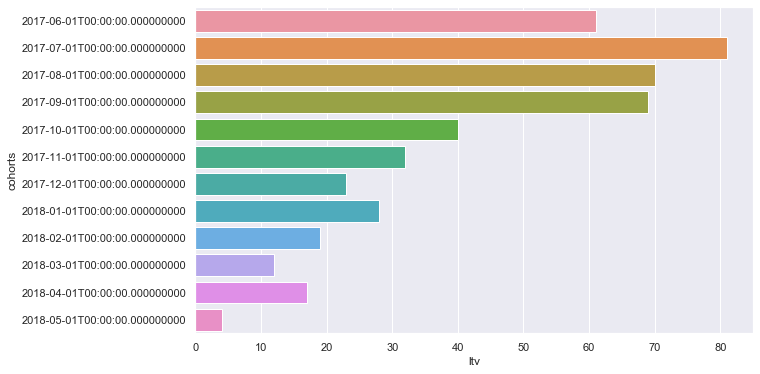

------ 1 LTV----
      cohorts   ltv
0  2017-06-01  61.0
1  2017-07-01  81.0
2  2017-08-01  70.0
3  2017-09-01  69.0
4  2017-10-01  40.0
5  2017-11-01  32.0
6  2017-12-01  23.0
7  2018-01-01  28.0
8  2018-02-01  19.0
9  2018-03-01  12.0
10 2018-04-01  17.0
11 2018-05-01   4.0

Средний LTV ltv    38.0
dtype: float64
LTV ПО ИСТОЧНИКУ № 2


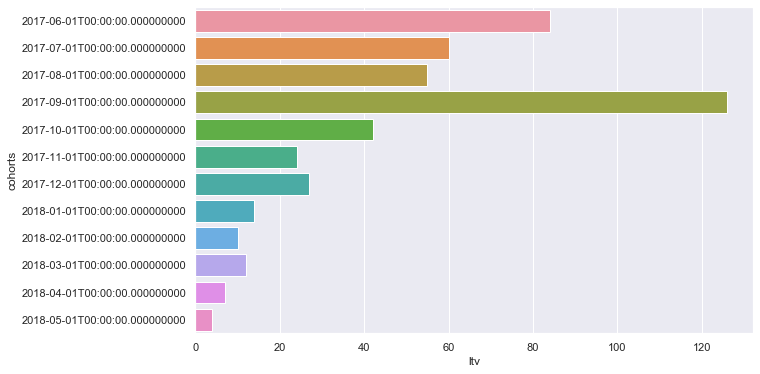

------ 2 LTV----
      cohorts    ltv
0  2017-06-01   84.0
1  2017-07-01   60.0
2  2017-08-01   55.0
3  2017-09-01  126.0
4  2017-10-01   42.0
5  2017-11-01   24.0
6  2017-12-01   27.0
7  2018-01-01   14.0
8  2018-02-01   10.0
9  2018-03-01   12.0
10 2018-04-01    7.0
11 2018-05-01    4.0

Средний LTV ltv    38.75
dtype: float64
LTV ПО ИСТОЧНИКУ № 3


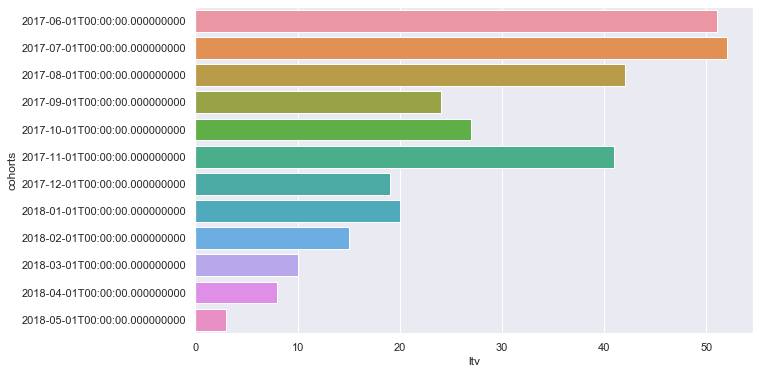

------ 3 LTV----
      cohorts   ltv
0  2017-06-01  51.0
1  2017-07-01  52.0
2  2017-08-01  42.0
3  2017-09-01  24.0
4  2017-10-01  27.0
5  2017-11-01  41.0
6  2017-12-01  19.0
7  2018-01-01  20.0
8  2018-02-01  15.0
9  2018-03-01  10.0
10 2018-04-01   8.0
11 2018-05-01   3.0

Средний LTV ltv    26.0
dtype: float64
LTV ПО ИСТОЧНИКУ № 5


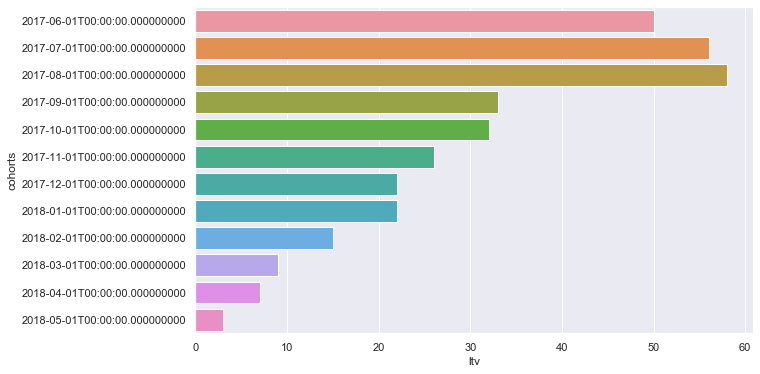

------ 5 LTV----
      cohorts   ltv
0  2017-06-01  50.0
1  2017-07-01  56.0
2  2017-08-01  58.0
3  2017-09-01  33.0
4  2017-10-01  32.0
5  2017-11-01  26.0
6  2017-12-01  22.0
7  2018-01-01  22.0
8  2018-02-01  15.0
9  2018-03-01   9.0
10 2018-04-01   7.0
11 2018-05-01   3.0

Средний LTV ltv    27.75
dtype: float64
LTV ПО ИСТОЧНИКУ № 4


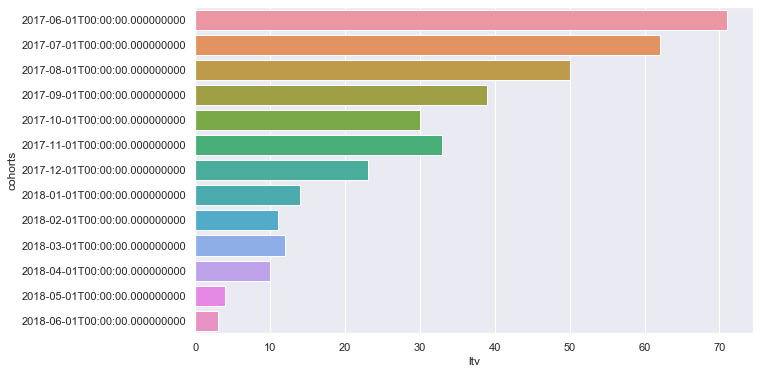

------ 4 LTV----
      cohorts   ltv
0  2017-06-01  71.0
1  2017-07-01  62.0
2  2017-08-01  50.0
3  2017-09-01  39.0
4  2017-10-01  30.0
5  2017-11-01  33.0
6  2017-12-01  23.0
7  2018-01-01  14.0
8  2018-02-01  11.0
9  2018-03-01  12.0
10 2018-04-01  10.0
11 2018-05-01   4.0
12 2018-06-01   3.0

Средний LTV ltv    27.846154
dtype: float64
LTV ПО ИСТОЧНИКУ № 9


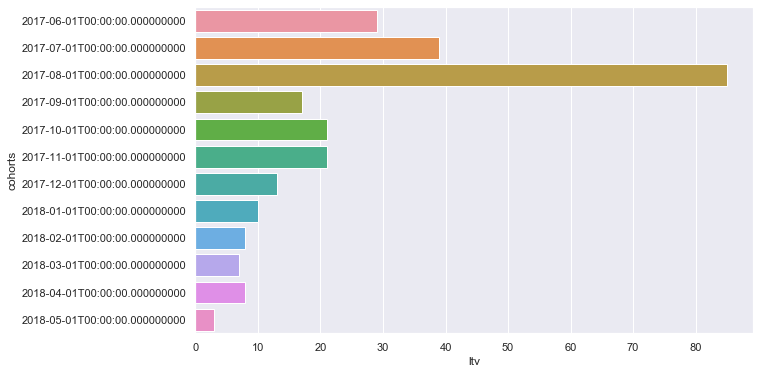

------ 9 LTV----
      cohorts   ltv
0  2017-06-01  29.0
1  2017-07-01  39.0
2  2017-08-01  85.0
3  2017-09-01  17.0
4  2017-10-01  21.0
5  2017-11-01  21.0
6  2017-12-01  13.0
7  2018-01-01  10.0
8  2018-02-01   8.0
9  2018-03-01   7.0
10 2018-04-01   8.0
11 2018-05-01   3.0

Средний LTV ltv    21.75
dtype: float64
LTV ПО ИСТОЧНИКУ № 10


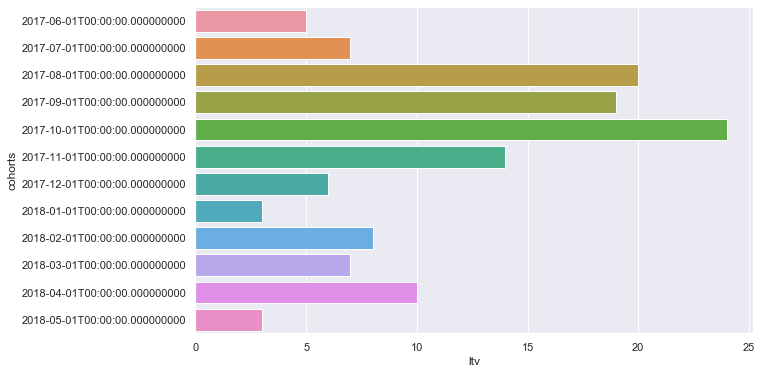

------ 10 LTV----
      cohorts   ltv
0  2017-06-01   5.0
1  2017-07-01   7.0
2  2017-08-01  20.0
3  2017-09-01  19.0
4  2017-10-01  24.0
5  2017-11-01  14.0
6  2017-12-01   6.0
7  2018-01-01   3.0
8  2018-02-01   8.0
9  2018-03-01   7.0
10 2018-04-01  10.0
11 2018-05-01   3.0

Средний LTV ltv    10.5
dtype: float64
LTV ПО ИСТОЧНИКУ № 7


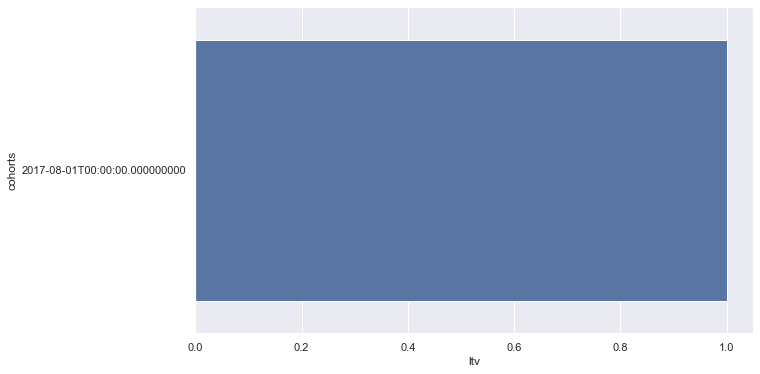

------ 7 LTV----
     cohorts  ltv
0 2017-08-01  1.0

Средний LTV ltv    1.0
dtype: float64


In [55]:
# creating cycle for visualisation data slices
orders_log_cohorts['source_Id'] = orders_log_cohorts['source_Id'].astype('str')

for i in orders_log_cohorts['source_Id'].unique():
    orders_log_cohorts_3 = orders_log_cohorts.loc[orders_log_cohorts['source_Id'] == i]
    ltv_pivot = orders_log_cohorts_3.pivot_table(index='first_buy_m', 
                                                 columns='lifetime', 
                                                 values='ltv', 
                                                 aggfunc='mean').round()
    ltv_total = ltv_pivot.sum(axis=1).reset_index()
    ltv_total.columns = ['cohorts','ltv']
    #barplot
    print('LTV ПО ИСТОЧНИКУ №',i)
    sb.set_style('darkgrid')
    plt.figure(figsize=(10, 6))
    sb.barplot(x='ltv', y='cohorts', data=ltv_total,orient='h')
    plt.show()
    print('------',i,'LTV----')
    print(ltv_total)
    print()
    print('Средний LTV',ltv_total.mean())

LTV ПО УСТРОЙСТВУ desktop


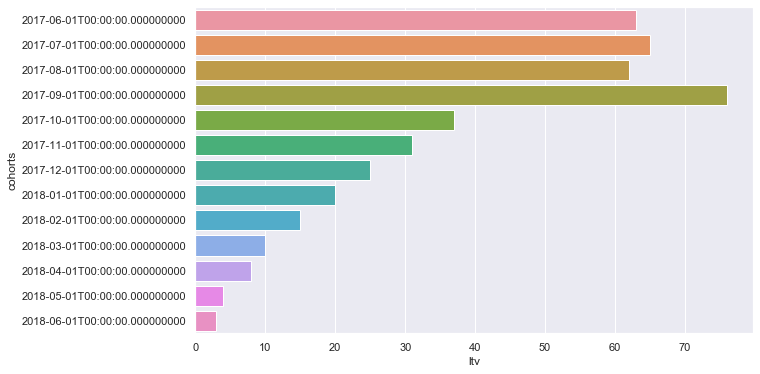

------ desktop LTV----
      cohorts   ltv
0  2017-06-01  63.0
1  2017-07-01  65.0
2  2017-08-01  62.0
3  2017-09-01  76.0
4  2017-10-01  37.0
5  2017-11-01  31.0
6  2017-12-01  25.0
7  2018-01-01  20.0
8  2018-02-01  15.0
9  2018-03-01  10.0
10 2018-04-01   8.0
11 2018-05-01   4.0
12 2018-06-01   3.0
Средний LTV ltv    32.230769
dtype: float64
LTV ПО УСТРОЙСТВУ touch


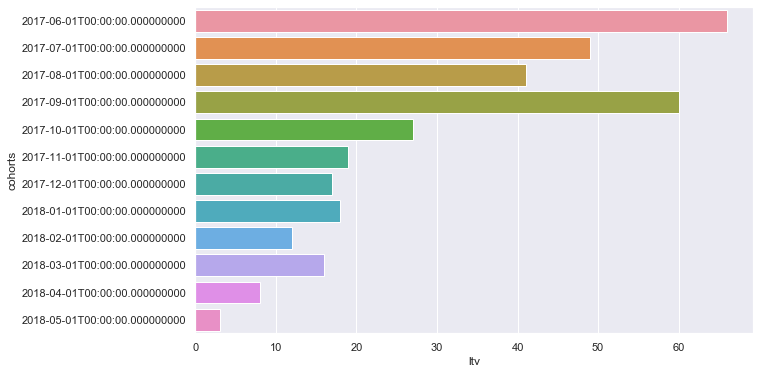

------ touch LTV----
      cohorts   ltv
0  2017-06-01  66.0
1  2017-07-01  49.0
2  2017-08-01  41.0
3  2017-09-01  60.0
4  2017-10-01  27.0
5  2017-11-01  19.0
6  2017-12-01  17.0
7  2018-01-01  18.0
8  2018-02-01  12.0
9  2018-03-01  16.0
10 2018-04-01   8.0
11 2018-05-01   3.0
Средний LTV ltv    28.0
dtype: float64


In [56]:
# creating cycle for visualisation data slices
for i in orders_log_cohorts['device'].unique():
    orders_log_cohorts_3 = orders_log_cohorts.loc[orders_log_cohorts['device'] == i]
    ltv_pivot = orders_log_cohorts_3.pivot_table(index='first_buy_m', 
                                                 columns='lifetime', 
                                                 values='ltv', 
                                                 aggfunc='mean').round()
    ltv_total = ltv_pivot.sum(axis=1).reset_index()
    ltv_total.columns = ['cohorts','ltv']
    #barplot
    print('LTV ПО УСТРОЙСТВУ',i)
    sb.set_style('darkgrid')
    plt.figure(figsize=(10, 6))
    sb.barplot(x='ltv', y='cohorts', data=ltv_total,orient='h')
    plt.show()
    print('------',i,'LTV----')
    print(ltv_total)
    print('Средний LTV',ltv_total.mean())

### Вывод

Мы посчитали, сколько денег приносят клиенты на срезах по типу источника привлечения и по типу используемого устройства.

Итак, больше всего нам могут рассказать источники привлечения, по которым нет никаких данных: 6, 7, 8. Источники 6 и 8 не привлекли новых пользователей, следовательно те ничего не ппотратили. Таким образом, маркетологам следует перестать инвестировать в эти источники привлечения. Источник №7 привлек одного клиента из самой молодой когорты, от него также можно отказаться.

Остальные источники, в целом, доказывают свою эффективность. Однако источник № 10 также вызывает вопросы. Возможно низкое значение среднего LTV всех когорт связано с тем, что отклик от этого источника идет со стороны относительно молодых когорт, которые еще не пользовались сервисом достаточно долго.

Изучив LTV в зависимости от используемого устройства, можно заметить, что тенденция изменения среднего чека в когортах, в целом, сохраняется. И, несмотря на то, что пользователи предпочитают пользоваться ПК-версией, средний LTV когорт отличается несильно. Менять подход к рекламе в зависимости от типа устройства не нужно. 

### Маркетинг

#### Стоимость рекламной кампании: всего, на каждый источник, по времени.

Как говорилось ранее, метрика LTV наиболее показательна, когда сравнивается с показателями затрат. В этом блоке будут рассчитаны средние затраты на привлечение одного пользователя(CAC), возврат на инвестиции в маркетинг (ROMI), а также будет дана сводка по общим затратам. Начнем с последнего пункта.

In [57]:
print(costs.columns)
print()
print(costs.info())
print()
print(costs.head(10))

Index(['source_id', 'dt', 'costs'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2528 non-null   int64         
 1   dt         2528 non-null   datetime64[ns]
 2   costs      2528 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 79.0 KB
None

   source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08
5          1 2017-06-06  40.39
6          1 2017-06-07  40.59
7          1 2017-06-08  56.63
8          1 2017-06-09  40.16
9          1 2017-06-10  43.24


In [58]:
#total costs calculation
total_costs = costs['costs'].sum()
#monthly costs
costs['dt_m'] = costs['dt'].astype('datetime64[M]')
costs_monthly = costs.groupby('dt_m').agg({'costs':'sum'}).reset_index()
costs_monthly_mean = costs_monthly['costs'].mean()

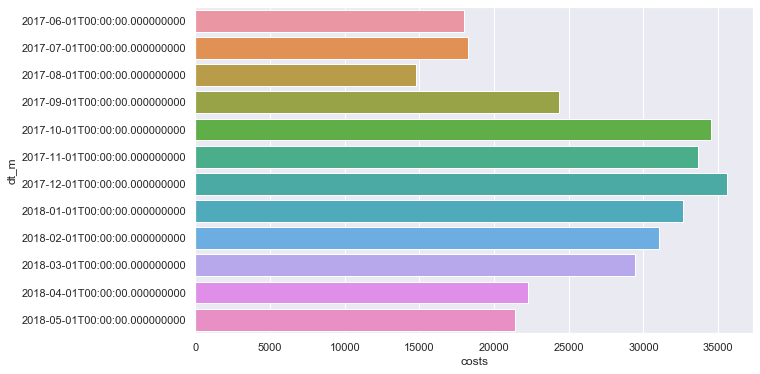

In [59]:
#monthly costs barplot
sb.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sb.barplot(x='costs', y='dt_m', data=costs_monthly,orient='h')
plt.show()

In [60]:
#costs data output
print('Истоговые расходы {:.1f}'.format(total_costs))
print()
print('Среднемесячные расходы {:.1f}'.format(costs_monthly_mean))

Истоговые расходы 316039.1

Среднемесячные расходы 26336.6


Мы видим, что в целом на привлечение клиентов было потрачено 316 039 рублей, при этом, в среднем в каждый месяц из бюджета на привлечение клиентов уходило 26 337 рублей. Среди прочих месяцев особенно выделились осенние-зимние месяцы - стоимость прислечения в них колебалась от 30 000 до 35 000 рублей.

Это снова говорит об ажиотаже во время начала театрального сезона и новогодних праздников.

In [61]:
#examining costs per source
costs_source = costs.groupby('source_id').agg({'costs':'sum'})
print(costs_source.sort_values(by='costs'))

               costs
source_id           
9            5517.49
10           5822.49
1           20833.27
2           42806.04
5           51757.10
4           61073.60
3          128229.11


Очень интересно распределен рекламный бюджет среди источников привлечения. Больше всего денежных средств направлено на источник № 3. Однако наиболее эффективными, основываясь на ltv, являются источники №1 и № 2. 

Поэтому, еще одной рекомендацией станет перераспределение бюджета в пользу наиболее эффективных источников.

От источников 6,7,8 стоит отказаться, хоть они и бесплатные. Наверняка для построения алгоритма привлечения клиентов человеческие и временные ресурсы (которые сложно представить в денежном эквиваленте) тратятся на "раскрутку" вышеупомянутых источников.

In [62]:
#table cost per source with time
costs['dt_m'] = costs['dt'].astype('datetime64[M]')
costs_source_time = costs.groupby(['source_id','dt_m']).agg({'costs':'sum'}).reset_index()

In [63]:
print(costs_source_time)
def source_wd(number):
    if number == 1:
        return 'One'
    if number == 2:
        return 'Two'
    if number == 3:
        return 'Three'
    if number == 4:
        return 'Four'
    if number == 5:
        return 'Five'
    if number == 6:
        return 'Six'
    if number == 7:
        return 'Seven'
    if number == 8:
        return 'Eight'
    if number == 9:
        return 'Nine'
    return 'Ten'

costs_source_time['source_wd'] = costs_source_time['source_id'].apply(source_wd)
print(costs_source_time)

    source_id       dt_m    costs
0           1 2017-06-01  1125.61
1           1 2017-07-01  1072.88
2           1 2017-08-01   951.81
3           1 2017-09-01  1502.01
4           1 2017-10-01  2315.75
..        ...        ...      ...
79         10 2018-01-01   614.35
80         10 2018-02-01   480.88
81         10 2018-03-01   526.41
82         10 2018-04-01   388.25
83         10 2018-05-01   409.86

[84 rows x 3 columns]
    source_id       dt_m    costs source_wd
0           1 2017-06-01  1125.61       One
1           1 2017-07-01  1072.88       One
2           1 2017-08-01   951.81       One
3           1 2017-09-01  1502.01       One
4           1 2017-10-01  2315.75       One
..        ...        ...      ...       ...
79         10 2018-01-01   614.35       Ten
80         10 2018-02-01   480.88       Ten
81         10 2018-03-01   526.41       Ten
82         10 2018-04-01   388.25       Ten
83         10 2018-05-01   409.86       Ten

[84 rows x 4 columns]


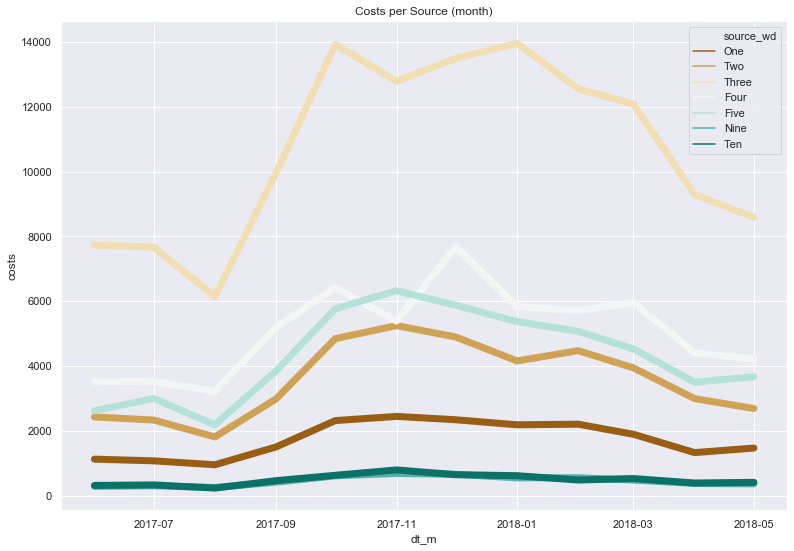

In [64]:
#creating plot for each source
sb.set(style='darkgrid')
plt.figure(figsize=(13, 9))
plt.title('Costs per Source (month)')
kwargs = {'linewidth':7}
sb.lineplot(x='dt_m', 
           y='costs', 
           hue='source_wd', 
           data= costs_source_time,
           palette='BrBG',
           **kwargs)
plt.show()

Визуализация распределения трат на различные источники более наглядно показывает пропасть между бюджетом, выделенным на третий источник привлечения клиентов и бюджетами на остальные источники. 

Посколько наиболее эффективными, как мы уже выяснили, являются источники 1 и 2, их следует разработать в большей степени. Также бОльшей порции рекламного бюджета заслуживают источники 4 и 5

### Вывод

Проведя первичный анализ трат, можно сформулировать краткие выводы:

    1) В среднем в месяц на источники привлечения клиентов тратится около 27 000. Среди прочих месяцев особенно выделились осенние-зимние месяцы - стоимость прислечения в них колебалась от 30 000 до 35 000 рублей. Это говорит о возможном ажиотаже, возникающем во время открытия театрального сезона и начала новогодних праздников.
    2) Больше всего денежных средств направлено на источник № 3. Однако наиболее эффективными, основываясь на ltv, являются источники №1 и № 2. Также бОльшей порции рекламного бюджета заслуживают источники 4 и 5. Рекомендацией станет перераспределение бюджета в пользу наиболее эффективных источников.
    3) От источников 6,7,8 стоит отказаться, хоть они и бесплатные, т.к. их маркетинг отвлекает нематериальные ресурсы компании (время сотрудников).
    

#### Затраты на привлечение одного клиента по источнику.

Понимание финансового здоровья компании может быть сформировано с помощью соотнесения метрик юнит-экономики.
Речь идет о сравнении LTV (посчитанного в прошлом блоке) и CAC (стоимость привлечения одного покупателя).

Рассчитаем эти метрики и сопоставим между собой в зависимости от источника привлечения пользователей.

In [65]:
#preparing number of buyers for cac PART 1
orders_log_cohorts['first_buy_dt'] = orders_log_cohorts['first_buy'].dt.date
n_buyers = orders_log_cohorts.groupby('first_buy_dt')['n_buyers'].sum()

In [66]:
#preparing number of buyers for cac PART 2
n_buyers = n_buyers.reset_index()
n_buyers = n_buyers.rename(columns={'first_buy_dt':'dt'})
n_buyers['dt'] = n_buyers['dt'].astype('datetime64[ns]')

In [67]:
costs = costs.merge(n_buyers,on='dt', how='left')
print(costs)

      source_id         dt  costs       dt_m  n_buyers
0             1 2017-06-01  75.20 2017-06-01     495.0
1             1 2017-06-02  62.25 2017-06-01     340.0
2             1 2017-06-03  36.53 2017-06-01     426.0
3             1 2017-06-04  55.00 2017-06-01      75.0
4             1 2017-06-05  57.08 2017-06-01     788.0
...         ...        ...    ...        ...       ...
2523         10 2018-05-27   9.92 2018-05-01      72.0
2524         10 2018-05-28  21.26 2018-05-01     175.0
2525         10 2018-05-29  11.32 2018-05-01     160.0
2526         10 2018-05-30  33.15 2018-05-01     212.0
2527         10 2018-05-31  17.60 2018-05-01    1090.0

[2528 rows x 5 columns]


In [68]:
#cac calculation in a nice way
costs['source_id'] = costs['source_id'].astype('str')

for i in orders_log_cohorts['source_Id'].unique():
    # part where we are making ltv table
    orders_log_cohorts_4 = orders_log_cohorts.loc[orders_log_cohorts['source_Id'] == i]
    ltv_pivot = orders_log_cohorts_4.pivot_table(index='first_buy_m', 
                                                 columns='lifetime', 
                                                 values='ltv', 
                                                 aggfunc='mean').round()
    ltv_total = ltv_pivot.sum(axis=1).reset_index()
    ltv_total.columns = ['cohorts','ltv']
    #part where we are making  cac table
    costs_cohorts = costs.loc[costs['source_id'] == i]
    costs_cac = costs_cohorts.groupby('dt_m').agg({'n_buyers':'sum','costs':'sum'}).reset_index()
    costs_cac['cac'] = costs_cac['costs'] / costs_cac['n_buyers']
    costs_cac = costs_cac.rename(columns={'dt_m':'cohorts'})
    #part where we are merging tables cac and ltv
    cac_and_ltv = ltv_total.merge(costs_cac,on='cohorts')
    #making nice output as usual
    print('------',i,'LTV & CAC----')
    print(cac_and_ltv[['cohorts','ltv','cac']])
    print()
    print('Средний LTV',ltv_total['ltv'].mean())
    print('Средний CAC',cac_and_ltv['cac'].mean())

------ 1 LTV & CAC----
      cohorts   ltv       cac
0  2017-06-01  61.0  0.224718
1  2017-07-01  81.0  0.326103
2  2017-08-01  70.0  0.386287
3  2017-09-01  69.0  0.342456
4  2017-10-01  40.0  0.318229
5  2017-11-01  32.0  0.317430
6  2017-12-01  23.0  0.330491
7  2018-01-01  28.0  0.438024
8  2018-02-01  19.0  0.402571
9  2018-03-01  12.0  0.348892
10 2018-04-01  17.0  0.439421
11 2018-05-01   4.0  0.345645

Средний LTV 38.0
Средний CAC 0.3516888727919772
------ 2 LTV & CAC----
      cohorts    ltv       cac
0  2017-06-01   84.0  0.484604
1  2017-07-01   60.0  0.709152
2  2017-08-01   55.0  0.735004
3  2017-09-01  126.0  0.680725
4  2017-10-01   42.0  0.665796
5  2017-11-01   24.0  0.681251
6  2017-12-01   27.0  0.691389
7  2018-01-01   14.0  0.833047
8  2018-02-01   10.0  0.817082
9  2018-03-01   12.0  0.726712
10 2018-04-01    7.0  0.990963
11 2018-05-01    4.0  0.633406

Средний LTV 38.75
Средний CAC 0.7207609893066311
------ 3 LTV & CAC----
      cohorts   ltv       cac
0  2017-0

Первое, что бросается в глаза: каждая когорта окупает затраты на привлечение клиентов, причем в разы.

Тенденции сохраняются для всех источников: 3-й наиболее дорогой, 4 и 5 сопоставимы с этой когортой по стоимости привлечения клиентов, а самые бюджетные и в то же время, самые эффективные.

### Вывод

Система привлечения клиентов работает эффективно с точки зрения стоимости привлечения одного клиента.

Необходимо направить больше средств/бюджета на наиболее эффективные источники: 1 и 2

#### Расчет окупаемости расходов на маркетинг.

Сейчас уже кажется очевидным, что расходы на маркетинг окупаются почти сразу, тем не менее числовые характеристики лучше это отразят.

Преобразуем выведенные данные и посчитаем средний ROMI когорты с разбивкой по источникам.

ROMI - берем orders_log_cohorts добавляем костс из костс, считаем cac, romi, делаем все дальше по шаблону

In [73]:
# adding column costs from costs to orders_log_cohorts
costs_mid_table = costs[['dt','costs']].copy()
costs_mid_table = costs_mid_table.rename(columns={'dt':'first_buy_dt'})
costs_mid_table['first_buy_dt'] = costs_mid_table['first_buy_dt'].astype('datetime64[ns]')
orders_log_cohorts['first_buy_dt'] = orders_log_cohorts['first_buy_dt'].astype('datetime64[ns]')
orders_log_cohorts = orders_log_cohorts.merge(costs_mid_table,on='first_buy_dt')
# print(orders_log_cohorts.head(10))

               buy_ts  revenue                   uid           first_buy  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
1 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
2 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
3 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
4 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
5 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
6 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
7 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00   
8 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00   
9 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00   

    buy_ts_m first_buy_m  lifetime   device source_Id  n_buyers    ltv  \
0 2017-06-01  2017-06-01         0  desktop         1         1  17.00   
1 2017-06-01  2

In [74]:
#calculating cac
orders_log_cohorts['cac'] = orders_log_cohorts['costs'] / orders_log_cohorts['n_buyers']

In [75]:
#calculating romi
orders_log_cohorts['romi'] = orders_log_cohorts['ltv'] / orders_log_cohorts['cac']

In [84]:
#creating romi pivot table with device diversification
for i in orders_log_cohorts['source_Id'].unique():
    # part where we are making romi table
    orders_log_cohorts_6 = orders_log_cohorts.loc[orders_log_cohorts['source_Id'] == i]
    romi_pivot = orders_log_cohorts_6.pivot_table(
        index='first_buy_m', 
        columns='lifetime', 
        values='romi', 
        aggfunc='mean')
    romi_pivot = romi_pivot.cumsum(axis=1).round(2)
    romi_pivot_mean = romi_pivot.cumsum(axis=1).mean(axis=0)
    # here comes a nice output
    print('=========== Источник',i,' ===========')
    print(romi_pivot_mean)
    print()
    print()

=========== Источник 1  ===========
lifetime
0      0.156667
1      0.521818
2      1.061000
3      1.908889
4      2.976250
5      3.977143
6      5.831667
7      8.074000
8     10.682500
9     13.966667
10    16.150000
11    18.940000
dtype: float64


=========== Источник 2  ===========
lifetime
0      0.160000
1      0.532727
2      1.105000
3      1.954444
4      3.253750
5      5.058571
6      7.606667
7     11.232000
8     15.957500
9     18.290000
10    21.425000
11    25.210000
dtype: float64


=========== Источник 3  ===========
lifetime
0      0.138333
1      0.437273
2      0.917000
3      1.660000
4      2.660000
5      3.921429
6      5.625000
7      7.776000
8     10.535000
9     15.226667
10    14.085000
11    17.610000
dtype: float64


=========== Источник 5  ===========
lifetime
0      0.148333
1      0.440000
2      0.960000
3      1.708889
4      2.670000
5      3.331429
6      4.746667
7      6.802000
8      9.337500
9     13.040000
10    13.800000
11    10.650000
d

### Вывод

С точки зрения окупаемости вложенных средств у компании все хорошо. Все источники окупаются следующим образом:

    1) Источники 1 и 2 - за три месяца
    2) Источники 3-9 (кроме, конечно же 6-8) - за четыре
    3) Источнику 10 окупается за пять месяцев.
    
Данных достаточно для формирования общих выводов и рекомендаций для маркетологов компании Яндекс

## Часть 3. Рекомендации.

#### Общие выводы.

Сервис пользуется популярностью и постоянно привлекает пользователей.

Интерес у пользователей подвержен сезонности, следовательно для увеличения покупок в эти пиковые периоды можно рассмотреть проведение дополнительных акций для каждой когорты.

Также в первый месяц существования каждой когорты средний чек минимален, то есть, пользователи не совершают большого числа покупок. Для корректировки этого показателя в первый месяц предлагается ввести акцию на первый заказ, побуждающую к приобретению нескольких билетов за меньшую стоимость одного билета (отсюда больший объем комиссии сервису станет выше)

#### Устройства.

Изучив LTV в зависимости от используемого устройства, можно заметить, что тенденция изменения среднего чека в когортах (сезонные пики), в целом, сохраняется. И, несмотря на то, что пользователи предпочитают пользоваться ПК-версией, средний LTV когорт отличается несильно. Менять подход к рекламе в зависимости от типа устройства не нужно. 

#### Источники трафика.

    1) В среднем в месяц на источники привлечения клиентов тратится около 27 000. Среди прочих месяцев особенно выделились осенние-зимние месяцы - стоимость привлечения в них колебалась от 30 000 до 35 000 рублей. Это говорит о возможном ажиотаже, возникающем во время открытия театрального сезона и начала новогодних праздников.
    2) Больше всего денежных средств направлено на источник № 3. Однако наиболее эффективными, основываясь на ltv, а также на ROMI, являются источники №1 и № 2. Также бОльшей порции рекламного бюджета заслуживают источники 4 и 5. Рекомендацией станет перераспределение бюджета в пользу наиболее эффективных источников.
    3) От источников 6,7,8 стоит отказаться, хоть они и бесплатные, т.к. их маркетинг отвлекает нематериальные ресурсы компании (время сотрудников).
    
Окупаемость когорт по источникам трафика (ROMI) подтверждает эффективность источников 1 и 2 (период окупаемости 3 месяца) и переоцененность 3 - го (он примерно так же эффективен, как и 4 и 5). 